In [31]:
import os
import random
import string
import time
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader



## for BLEU score calculation
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
nltk.download('punkt')  ## ensure necessary data is download

##    reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
Using device: cpu


In [ ]:
def load_sentences(en_file_path, ur_file_path): # load english n urdu sentence from files 
    en_sentences, ur_sentences = [], []
    with open(en_file_path, 'r', encoding='utf-8') as en_file, \
         open(ur_file_path, 'r', encoding='utf-8') as ur_file:
        for en_line, ur_line in zip(en_file, ur_file):
            en_sentences.append(en_line.strip())
            ur_sentences.append(ur_line.strip())
    return en_sentences, ur_sentences





def split_data(data, train_ratio=0.7, val_ratio=0.15): # we are splitting data into 70% training ,15% testing and the remianing into validation
    train_size = int(train_ratio * len(data))
    val_size = int(val_ratio * len(data))
    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]
    return train_data, val_data, test_data
    

def clean_text(text):  # removing punctuation, lowercases text, and strips whitespace.
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = ' '.join(text.split())
    return text.strip()






def preprocess_data(en_sentences, ur_sentences):  # we will return both english n urdu sentence in pairs
    data = [(clean_text(ur), clean_text(en))
            for ur, en in zip(ur_sentences, en_sentences)]
    return data


In [ ]:
file_path = "/kaggle/input/kiiiii"  # since ive used kaggle

en_dev_path = os.path.join(file_path, "eng_Latn.dev")
en_devtest_path = os.path.join(file_path, "eng_Latn.devtest")
ur_dev_path = os.path.join(file_path, "urd_Arab.dev")
ur_devtest_path = os.path.join(file_path, "urd_Arab.devtest")



en_dev_sentences, ur_dev_sentences = load_sentences(en_dev_path, ur_dev_path)
en_devtest_sentences, ur_devtest_sentences = load_sentences(en_devtest_path, ur_devtest_path)

en_combined = en_dev_sentences + en_devtest_sentences
ur_combined = ur_dev_sentences + ur_devtest_sentences

full_data = preprocess_data(en_combined, ur_combined)

random.shuffle(full_data)
train_list, val_list, test_list = split_data(full_data)

print(f"Training size: {len(train_list)}")
print(f"Validation size: {len(val_list)}")
print(f"Test size: {len(test_list)}")


In [ ]:
## special tokens
PAD_TOKEN = "<pad>"
SOS_TOKEN = "<sos>"
EOS_TOKEN = "<eos>"
UNK_TOKEN = "<unk>"



###  we will build voc with min freq
def build_vocab(sentences, min_freq=1, special_tokens=[PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]):
    word2idx = {token: idx for idx, token in enumerate(special_tokens)}
    idx2word = {idx: token for idx, token in enumerate(special_tokens)}
    token_freq = {}


    
    
    for sentence in sentences:
        for token in sentence.split():
            token_freq[token] = token_freq.get(token, 0) + 1
    
    for token, freq in token_freq.items():
        if freq >= min_freq and token not in word2idx:
            index = len(word2idx)
            word2idx[token] = index
            idx2word[index] = token
    
    return word2idx, idx2word




## now will voc from training data

train_ur_sentences = [pair[0] for pair in train_list]
train_en_sentences = [pair[1] for pair in train_list]

ur_word2idx, ur_idx2word = build_vocab(train_ur_sentences, min_freq=1)
en_word2idx, en_idx2word = build_vocab(train_en_sentences, min_freq=1)

ur_vocab_size = len(ur_word2idx)
en_vocab_size = len(en_word2idx)
print(f"urdu Vocabulary Size: {ur_vocab_size}")
print(f"english Vocabulary Size: {en_vocab_size}")


In [ ]:
print("\n first 10 urdu Tokens:") #### just seeing the first 10 tokens of each language
for i, token in enumerate(ur_word2idx):
    print(f"{i}: {token}")
    if i >= 9:
        break

print("\n first 10 eng Tokens:")
for i, token in enumerate(en_word2idx):
    print(f"{i}: {token}")
    if i >= 9:
        break


In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, data, max_len_src=50, max_len_tgt=50):
        self.data = data
        self.max_len_src = max_len_src
        self.max_len_tgt = max_len_tgt
    
    def __len__(self):
        return len(self.data)
    
    def sentence_to_ids(self, sentence, word2idx, add_sos_eos=False, max_len=50):
        tokens = sentence.split()
        if add_sos_eos:
            tokens = [SOS_TOKEN] + tokens + [EOS_TOKEN]
        tokens = tokens[:max_len]
        ids = [word2idx.get(token, word2idx[UNK_TOKEN]) for token in tokens]
        if len(ids) < max_len:
            ids += [word2idx[PAD_TOKEN]] * (max_len - len(ids))
        return ids
    
    def __getitem__(self, idx):
        ur_sentence, en_sentence = self.data[idx]
        src_ids = self.sentence_to_ids(ur_sentence, ur_word2idx, add_sos_eos=False, max_len=self.max_len_src)
        tgt_ids = self.sentence_to_ids(en_sentence, en_word2idx, add_sos_eos=True, max_len=self.max_len_tgt)
        return torch.tensor(src_ids, dtype=torch.long), torch.tensor(tgt_ids, dtype=torch.long)




train_dataset = TranslationDataset(train_list)
val_dataset = TranslationDataset(val_list)
test_dataset = TranslationDataset(test_list)





batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [ ]:
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.W_ih = nn.Parameter(torch.Tensor(4 * hidden_size, input_size))
        self.W_hh = nn.Parameter(torch.Tensor(4 * hidden_size, hidden_size))
        self.b_ih = nn.Parameter(torch.Tensor(4 * hidden_size))
        self.b_hh = nn.Parameter(torch.Tensor(4 * hidden_size))
        self.reset_parameters()
    
    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)
    
    def forward(self, x, hx):
        h, c = hx
        gates = (torch.matmul(x, self.W_ih.T) + self.b_ih) + \
                (torch.matmul(h, self.W_hh.T) + self.b_hh)
        i, f, g, o = gates.chunk(4, 1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        g = torch.tanh(g)
        o = torch.sigmoid(o)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next







class Encoder(nn.Module):
    def __init__(self, embed_size=64, hidden_size=64, vocab_size=0):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=ur_word2idx[PAD_TOKEN])
        self.lstm_cell = CustomLSTMCell(embed_size, hidden_size)
        self.hidden_size = hidden_size
    
    def forward(self, src):
        embedded = self.embedding(src)
        batch_size, seq_len, _ = embedded.size()
        
        h = torch.zeros(batch_size, self.hidden_size, device=src.device)
        c = torch.zeros(batch_size, self.hidden_size, device=src.device)
        
        outputs = []
        for t in range(seq_len):
            h, c = self.lstm_cell(embedded[:, t, :], (h, c))
            outputs.append(h.unsqueeze(1))
        
        outputs = torch.cat(outputs, dim=1)
        return outputs, (h, c)





class BahdanauAttention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size, attn_size):
        super(BahdanauAttention, self).__init__()
        self.W_enc = nn.Linear(enc_hidden_size, attn_size)
        self.W_dec = nn.Linear(dec_hidden_size, attn_size)
        self.V = nn.Linear(attn_size, 1)
    
    def forward(self, enc_outputs, dec_hidden):
        src_len = enc_outputs.size(1)
        dec_hidden_expanded = dec_hidden.unsqueeze(1).repeat(1, src_len, 1)
        score = torch.tanh(self.W_enc(enc_outputs) + self.W_dec(dec_hidden_expanded))
        score = self.V(score).squeeze(-1)
        
        attn_weights = torch.softmax(score, dim=1)
        context = torch.bmm(attn_weights.unsqueeze(1), enc_outputs).squeeze(1)
        return context, attn_weights






class Decoder(nn.Module):
    def __init__(self, embed_size=64, hidden_size=64, vocab_size=0, attention=None):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=en_word2idx[PAD_TOKEN])
        self.lstm_cell = CustomLSTMCell(embed_size + hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, vocab_size)
        self.attention = attention
        self.hidden_size = hidden_size
    
    def forward(self, tgt, hidden, cell, enc_outputs):
        batch_size, seq_len = tgt.size()
        outputs = []
        
        input_token = tgt[:, 0]
        
        for t in range(1, seq_len):
            context, attn_weights = self.attention(enc_outputs, hidden)
            emb = self.embedding(input_token)
            lstm_input = torch.cat([emb, context], dim=1)
            
            hidden, cell = self.lstm_cell(lstm_input, (hidden, cell))
            logits = self.fc_out(hidden)
            outputs.append(logits.unsqueeze(1))
            
            input_token = tgt[:, t]
        
        outputs = torch.cat(outputs, dim=1)
        return outputs






class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, src, tgt):
        enc_outputs, (h, c) = self.encoder(src)
        outputs = self.decoder(tgt, h, c, enc_outputs)
        return outputs


In [ ]:
#### hyperparameters
embed_size = 64
hidden_size = 64
attn_size = 128
num_epochs = 50
learning_rate = 0.001
batch_size = 64
max_len_src = 50
max_len_tgt = 50



attention = BahdanauAttention(enc_hidden_size=hidden_size, dec_hidden_size=hidden_size, attn_size=attn_size)
encoder = Encoder(embed_size=embed_size, hidden_size=hidden_size, vocab_size=ur_vocab_size)
decoder = Decoder(embed_size=embed_size, hidden_size=hidden_size, vocab_size=en_vocab_size, attention=attention)
model = Seq2Seq(encoder, decoder).to(device)




criterion = nn.CrossEntropyLoss(ignore_index=en_word2idx[PAD_TOKEN])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Model, criterion, and optimizer initialized.")


In [ ]:
def compute_bleu(references, hypotheses): ## for BLEU score
   
    smoothie = SmoothingFunction().method4
    return corpus_bleu(references, hypotheses, smoothing_function=smoothie) * 100


In [ ]:
def calculate_accuracy(outputs, targets, pad_idx=en_word2idx[PAD_TOKEN]):
    outputs = outputs.argmax(dim=2)
    targets = targets[:, 1:]
    mask = (targets != pad_idx)
    correct = (outputs == targets) & mask
    accuracy = correct.sum().float() / mask.sum().float()
    return accuracy



def decode_sentence(ids, idx2word):
    words = []
    for i in ids:
        w = idx2word.get(i, UNK_TOKEN)
        if w == EOS_TOKEN:
            break
        if w not in [SOS_TOKEN, PAD_TOKEN]:
            words.append(w)
    return " ".join(words)





def translate(model, src_ids, max_len=50):
    model.eval()
    with torch.no_grad():
        src = torch.tensor(src_ids, dtype=torch.long).unsqueeze(0).to(device)
        enc_outputs, (h, c) = model.encoder(src)
        
        tgt_sentence = [en_word2idx[SOS_TOKEN]]
        for _ in range(max_len):
            input_token = torch.tensor([tgt_sentence[-1]], dtype=torch.long).unsqueeze(0).to(device)
            context, attn_weights = model.decoder.attention(enc_outputs, h)
            emb = model.decoder.embedding(input_token).squeeze(1)
            lstm_input = torch.cat([emb, context], dim=1)
            h, c = model.decoder.lstm_cell(lstm_input, (h, c))
            logits = model.decoder.fc_out(h)
            next_word = logits.argmax(dim=1).item()
            tgt_sentence.append(next_word)
            if next_word == en_word2idx[EOS_TOKEN]:
                break
        return tgt_sentence[1:]


In [22]:
# Lists for recording metrics
training_loss_list = []
validation_loss_list = []
validation_bleu_list = []



best_val_loss = float('inf')
model_save_path = "checkpoint_best_model.pt"

# early stopping criteria based on validation loss is hanging around a single value
stability_patience = 5
min_improvement = 0.0005
no_improvement_count = 0
previous_val_loss = None

max_epochs = 50 # adjust the epoch

for epoch in range(1, max_epochs+1):
    start_time = time.time()
    
    # training Phase....... the real deal
    model.train()
    sum_train_loss = 0.0
    for src_batch, tgt_batch in train_loader:
        src_batch, tgt_batch = src_batch.to(device), tgt_batch.to(device)
        optimizer.zero_grad()
        predictions = model(src_batch, tgt_batch)
        loss = criterion(predictions.reshape(-1, en_vocab_size), tgt_batch[:,1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        sum_train_loss += loss.item()
    
    avg_train_loss = sum_train_loss / len(train_loader)
    training_loss_list.append(avg_train_loss)


    
    
    # validation Phase to compute loss and BLEU
    model.eval()
    sum_val_loss = 0.0
    references = []
    hypotheses = []
    with torch.no_grad():
        for val_src, val_tgt in val_loader:
            val_src, val_tgt = val_src.to(device), val_tgt.to(device)
            val_out = model(val_src, val_tgt)
            val_loss = criterion(val_out.reshape(-1, en_vocab_size), val_tgt[:,1:].reshape(-1))
            sum_val_loss += val_loss.item()
            
           
            val_src_ids = val_src[0].tolist()
            pred_ids = translate(model, val_src_ids)
            pred_sentence = decode_sentence(pred_ids, en_idx2word)
            
            reference_sentence = decode_sentence(val_tgt[0].tolist()[1:], en_idx2word)
            
            references.append([reference_sentence.split()])
            hypotheses.append(pred_sentence.split())
    
    avg_val_loss = sum_val_loss / len(val_loader)
    validation_loss_list.append(avg_val_loss)




    
    
    # Compute BLEU score on validation set
    val_bleu_score = compute_bleu(references, hypotheses)
    validation_bleu_list.append(val_bleu_score)
    
    epoch_time = time.time() - start_time
    print(f"Epoch [{epoch}/{max_epochs}] "
          f"...Train Loss: {avg_train_loss:.4f} "
          f"...Val Loss: {avg_val_loss:.4f} "
          f"...Val BLEU: {val_bleu_score:.2f} "
          f"...Time: {epoch_time:.2f}s")
    
    # Check for best validation loss and save model
    if avg_val_loss < best_val_loss:
        improvement = best_val_loss - avg_val_loss
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_save_path)
        print(f"New best model saved! Val Loss: {best_val_loss:.4f}, Improvement: {improvement:.4f}")
        no_improvement_count = 0
    else:
        # Check if improvement is minimal
        if previous_val_loss is not None:
            improvement = previous_val_loss - avg_val_loss
            if improvement < min_improvement:
                no_improvement_count += 1
                print(f"No significant improvement in Val Loss. Count: {no_improvement_count}/{stability_patience}")
            else:
                no_improvement_count = 0
        else:
            no_improvement_count = 0
    
    previous_val_loss = avg_val_loss
    
    # Early stopping if stable
    if no_improvement_count >= stability_patience:
        print("Validation loss stabilized. Early stopping.")
        break


Epoch [1/50] ...Train Loss: 6.0470 ...Val Loss: 7.1850 ...Val BLEU: 2.36 ...Time: 28.04s
New best model saved! Val Loss: 7.1850, Improvement: inf
Epoch [2/50] ...Train Loss: 5.9520 ...Val Loss: 7.2083 ...Val BLEU: 6.52 ...Time: 28.14s
No significant improvement in Val Loss. Count: 1/5
Epoch [3/50] ...Train Loss: 5.8610 ...Val Loss: 7.2310 ...Val BLEU: 2.24 ...Time: 27.78s
No significant improvement in Val Loss. Count: 2/5
Epoch [4/50] ...Train Loss: 5.7681 ...Val Loss: 7.2332 ...Val BLEU: 2.51 ...Time: 28.03s
No significant improvement in Val Loss. Count: 3/5
Epoch [5/50] ...Train Loss: 5.6777 ...Val Loss: 7.2506 ...Val BLEU: 3.26 ...Time: 27.98s
No significant improvement in Val Loss. Count: 4/5
Epoch [6/50] ...Train Loss: 5.5887 ...Val Loss: 7.2793 ...Val BLEU: 2.82 ...Time: 26.56s
No significant improvement in Val Loss. Count: 5/5
Validation loss stabilized. Early stopping.


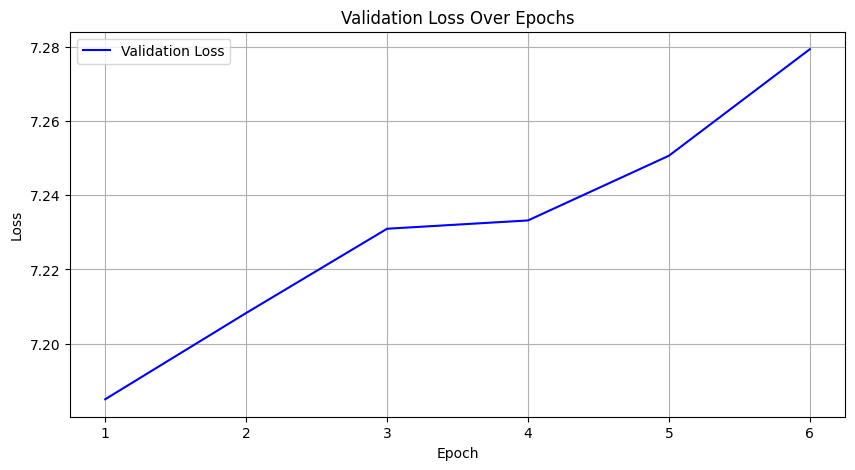

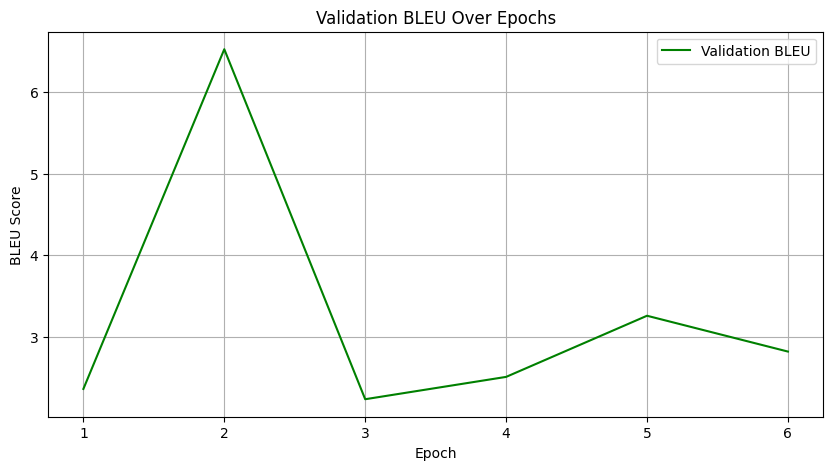

In [23]:
# plot Validation Loss
plt.figure(figsize=(10,5))
plt.plot(range(1, len(validation_loss_list)+1), validation_loss_list, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('validation_loss_plot.png')
plt.show()

# plot Validation BLEU
plt.figure(figsize=(10,5))
plt.plot(range(1, len(validation_bleu_list)+1), validation_bleu_list, label='Validation BLEU', color='green')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.title('Validation BLEU Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('validation_bleu_plot.png')
plt.show()


In [27]:
# Load the best model state
model.load_state_dict(torch.load("checkpoint_best_model.pt"))
model.eval()

predictions = []
references = []

with torch.no_grad():
    for ur_ids, en_ids in test_dataset:
        ur_ids_list = ur_ids.tolist()
        pred_ids = translate(model, ur_ids_list, max_len=50)
        pred_sentence = decode_sentence(pred_ids, en_idx2word)
        reference_sentence = decode_sentence(en_ids.tolist()[1:], en_idx2word)
        
        predictions.append(pred_sentence)
        references.append(reference_sentence)







# display a few examples
for i in range(min(5, len(test_list))):
    print(f"Sample {i+1}:")
    print(f"Urdu: {test_list[i][0]}")
    print(f"Reference (English): {references[i]}")
    print(f"Prediction (English): {predictions[i]}")
    print("-" * 50)


/tmp/ipykernel_24/2116994819.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint_best_model.pt"))


Sample 1:
Urdu: جب کسی آبادی میں تمام افراد ایک خاص فینو ٹایپیک خصلت کے لحاظ سے بالکل ایک جیسی شکل کے ہوتے ہیں تو انہیں ہم شَکَل مونومورفیک کہا جاتا ہے۔
Reference (English): when all individuals in a population are <unk> with regard to a particular <unk> <unk> they are known as <unk>
Prediction (English): the most of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first
--------------------------------------------------
Sample 2:
Urdu: سکھ لوگ اپنے مذہب کو گرومت کہتے ہیں جس کے معنی گورو کے مذہب ہیں۔ گورو کا تصوُّر تمام ہندوستانی مذاہب کا ایک بنیادی پہلو ہے لیکن سکھ مت میں اس کی اہمیت ایک بنیادی عقیدہ کی حیثیت سے ہے۔
Reference (English): sikhs call their religion <unk> which is <unk> for way of the <unk> the <unk> is a fundamental aspect of all indian religions but in sikhism has taken on an importance that forms the core of <unk> <unk>
Prediction (English): the most of the first of the first of the first of the fi

In [30]:
import pandas as pd

best_val_bleu = max(validation_bleu_list) if len(validation_bleu_list) > 0 else "N/A"

results_summary = {
    "Metric": ["Best Validation Loss", "Best Validation BLEU Score", "Epochs Completed"],
    "Value": [best_val_loss, best_val_bleu, epoch]
}

# convert to a DataFrame for a neat tabular display
results_df = pd.DataFrame(results_summary)

# display the DataFrame
print("Final Results Summary:")
display(results_df)  # If in Jupyter, display() gives a nice table. Otherwise, print(results_df).


Final Results Summary:


,Metric,Value
0,Best Validation Loss,7.185042
1,Best Validation BLEU Score,6.522279
2,Epochs Completed,6.000000
